In [61]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from matplotlib.ticker import MaxNLocator,AutoMinorLocator,MultipleLocator
import os
import pickle
from collections import defaultdict
import pandas as pd
import re

In [62]:
data_root = '../relative-comparison/'
raw_files = [(x[0], x[2]) for x in os.walk(data_root)][0]
raw_files

('../relative-comparison/',
 ['Exh+E.txt',
  'Exh+E+B.txt',
  'ICTS-m+ID+E.txt',
  'ICTS-m+ID.txt',
  'ICTS-m+ID+S.txt',
  'Exh+E+B+O.txt',
  'ICTS-m+ID+S+C.txt',
  'Exh+E+B+O+ID.txt',
  'ICTS-m.txt',
  'Exh+S+C+B+O.txt'])

In [63]:
icts_compare = True
if icts_compare:
    result_maps = dict()
    map_types = set()
    for file in raw_files[1]:
        name = os.path.splitext(file)[0]
        if name not in ['ICTS-m+ID+S']:
            df = pd.read_csv(data_root + file)
            result_maps[name] = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
            results = result_maps[name]
            for d in df.iterrows():
                data = d[1]
                setting = data[0]
                m = re.match('([A-Za-z0-9]*)-20x20-A(\d+)_T(\d+)',setting)
                map_type = m.group(1)
                map_types.add(map_type)
                agents = int(m.group(2))
                teams = int(m.group(3))
                results[map_type][teams][agents] = (data[2],data[1])
            print(results)
else:
    def correct_time(time):
        if time:
            return time
        else:
            return 120
    
    result_maps = dict()
    map_types = ['25','75']
    team_settings = [1,3]
    for map_type in map_types:
        for team_setting in team_settings:
            data_root = f'../comp-data/comparison_{map_type}percent_{team_setting}teams_maps/'
            raw_files = [(x[0], x[2]) for x in os.walk(data_root)][0][1]
            for file in raw_files:
                m = re.match('results_(.*).txt',file)
                algo = m.group(1)
                if algo == "ICTS":
                    algo = "Exh+E+B+O"
                if algo not in result_maps:
                    result_maps[algo] = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
                with open(data_root + file, "r") as f:
                    lines = f.readlines()
                    previous_unsolved = False
                    for l in [l.strip() for l in lines if l.strip() != ""]:
                        before, after = l.split(":")
                        after_list = eval(after)
                        agents = int(before)
                        fraction_solved = (len(after_list) - after_list.count(None)) / len(after_list)
                        solved_times = [correct_time(i) for i in after_list]
                        mean = sum(solved_times) / len(after_list)
                        if not previous_unsolved:
                            result_maps[algo][map_type][team_setting][agents] = (mean,fraction_solved)
                        if fraction_solved == 0:
                            previous_unsolved = True
    

defaultdict(<function <lambda> at 0x7fdfb305f5e0>, {'25': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fdfb35470d0>, {1: defaultdict(<class 'dict'>, {1: (0.0277781173790572, 1.0), 2: (0.1422902309786877, 1.0), 3: (0.4946847929205978, 1.0), 4: (4.464744824961818, 1.0), 5: (35.8325178909392, 1.0), 6: (120.03028177933942, 0.0)}), 3: defaultdict(<class 'dict'>, {1: (0.0256675133007229, 1.0), 2: (0.0692950503400061, 1.0), 3: (0.0985927241801982, 1.0), 4: (0.442538561062247, 1.0), 5: (1.7807991332592792, 1.0), 6: (10.600994839080377, 0.96), 7: (24.37970431487949, 1.0), 8: (93.2594782788804, 0.64), 9: (120.03656420807964, 0.0)})}), '75': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fdfb3540b80>, {1: defaultdict(<class 'dict'>, {1: (0.009369383919402, 1.0), 2: (0.9085959181989892, 1.0), 3: (43.09035470088042, 0.72), 4: (104.34168322050216, 0.18), 5: (120.03300411115896, 0.0)}), 3: defaultdict(<class 'dict'>, {1: (0.0063848912410321, 1.0), 2: (0.9797743757610442, 1.0), 3: (2

1
25


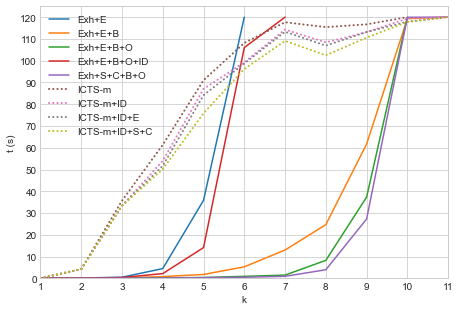

75


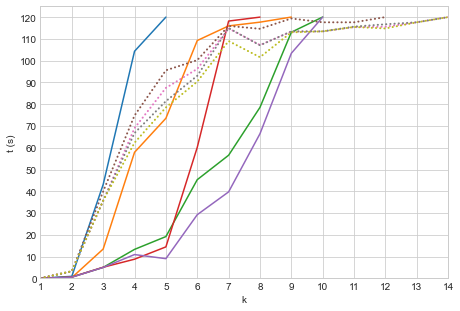

3
25


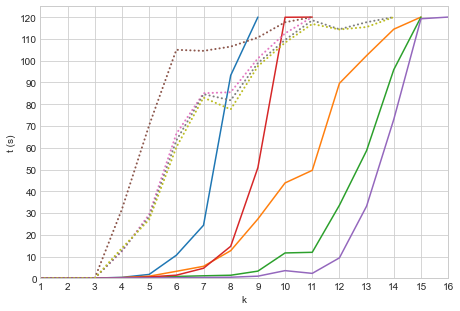

75


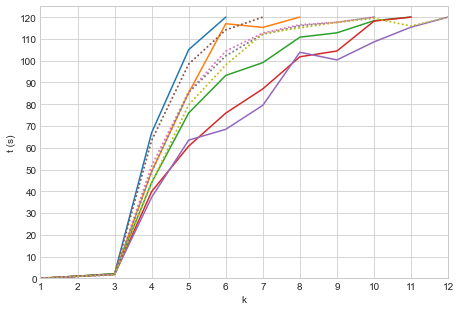

1
25


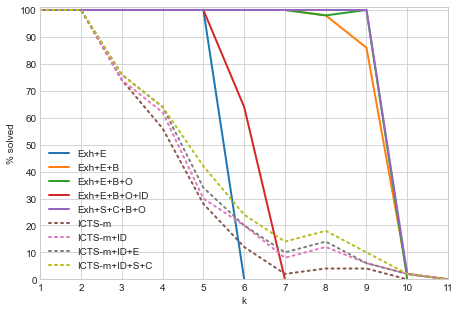

75


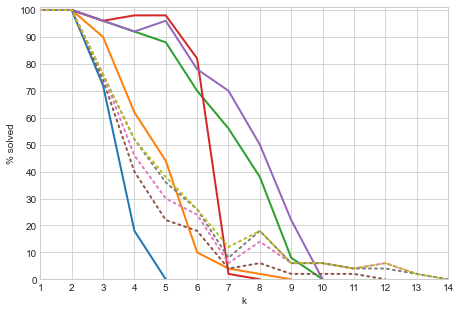

3
25


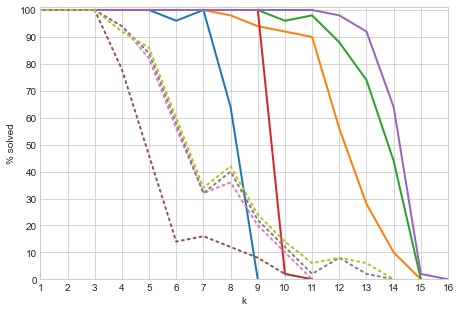

75


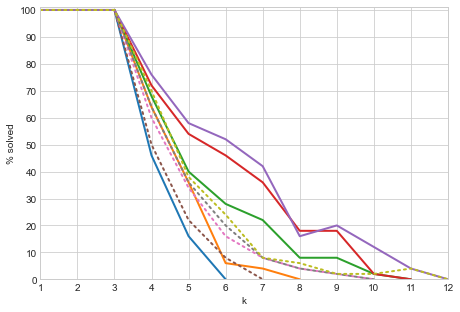

In [65]:
if icts_compare:
    plots_dir = '../docs/img/results/icts-comparison'
else:
    plots_dir = '../docs/img/results/relative-comparison'
legend = True
for team_size in [1,3]:
    print(team_size)
    for map_type in sorted(map_types):
        plt.style.use('seaborn-whitegrid')
        fig, ax = plt.subplots()
        plt.subplots_adjust(hspace=0.3)
        plt.tight_layout(pad=0)
        plt.margins(0, 0)
        plt.grid(True)
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(10))
        max_len = 0
        for name in result_maps:
            data = result_maps[name][map_type][team_size]
            max_len = max(max_len,len(data.keys()))
        plt.axis([1, max_len, 0, 125])
        print(map_type)
        for name in sorted(result_maps):
            data = result_maps[name][map_type][team_size]
#             print(result_maps[name][map_type][team_size])
            keys = list(data.keys())
            values = list(map(lambda x: x[0],data.values()))
#             print(times)
            if name.find('ICTS-m'):
                plt.plot(keys,values, label = name)
            else:
                plt.plot(keys,values,label=name,linestyle = (0,(0.1,2)),dash_capstyle = 'round',linewidth = 2,)
        plt.xlabel('k')
        plt.ylabel('t (s)')
        if legend:
            legend = False
            plt.legend()
        plt.savefig("{}/{}-{}.eps".format(plots_dir,map_type.lower(),team_size),bbox_inches="tight", pad_inches=0, format='eps')
#         plt.savefig("../plots/relative-comparison/{}-{}.png".format(map_type.lower(),team_size),bbox_inches="tight", pad_inches=0, format='png')
        plt.show()
legend = True
for team_size in [1,3]:
    print(team_size)
    for map_type in sorted(map_types):
        plt.style.use('seaborn-whitegrid')
        fig, ax = plt.subplots()
        plt.subplots_adjust(hspace=0.3)
        plt.tight_layout(pad=0)
        plt.margins(0, 0)
        plt.grid(True)
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(10))
        max_len = 0
        for name in result_maps:
            data = result_maps[name][map_type][team_size]
            max_len = max(max_len,len(data.keys()))
        plt.axis([1, max_len, 0, 101])
        print(map_type)
        for name in sorted(result_maps):
            data = result_maps[name][map_type][team_size]
#             print(result_maps[name][map_type][team_size])
            keys = list(data.keys())
            values = list(map(lambda x: 100 * x[1],data.values()))
#             print(times)
            if name.find('ICTS-m'):
                ax.plot(keys,values, label = name,linewidth = 2)
            else:
                ax.plot(keys,values,label=name,linestyle = (0,(1,2)),dash_capstyle = 'round',linewidth = 2,)
        plt.xlabel('k')
        plt.ylabel('% solved')
        if legend:
            legend = False
            plt.legend()
        plt.savefig("{}/{}-{}-p.eps".format(plots_dir,map_type.lower(),team_size),bbox_inches="tight", pad_inches=0, format='eps')
#         plt.savefig("../plots/relative-comparison/{}-{}-p.png".format(map_type.lower(),team_size),bbox_inches="tight", pad_inches=0, format='png')
        plt.show()